# Basic imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import master_functions as mf
# import imblearn

In [3]:
from matplotlib import rcParams
rcParams['figure.dpi'] = 600

# Get data

In [2]:
df_main = pd.read_pickle('main_df.pkl')

In [3]:
df_main.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1


In [4]:
df_main.shape

(2213180, 14)

In [9]:
X_main = df_main.drop(['virus', 'host', 'group', 'y'], axis=1) # !!! NOTE THE LACK OF GROUP_CODE IN DROP - FOR SMOTENC !!!
y_main = df_main['y']

In [10]:
df_main.groupby('y').size()

y
0    2196423
1      16757
dtype: int64

## Visualise X (after PCA)

In [ ]:
pre_smote_df = mf.get_pca(X_main, y_main, 2)

In [29]:
pre_smote_df.head()

,component 1,component 2,y
0,1.204658,0.001191,1
1,1.204242,0.001400,1
2,1.204203,0.001407,1
3,1.204160,0.001444,1
4,1.204201,0.001404,1


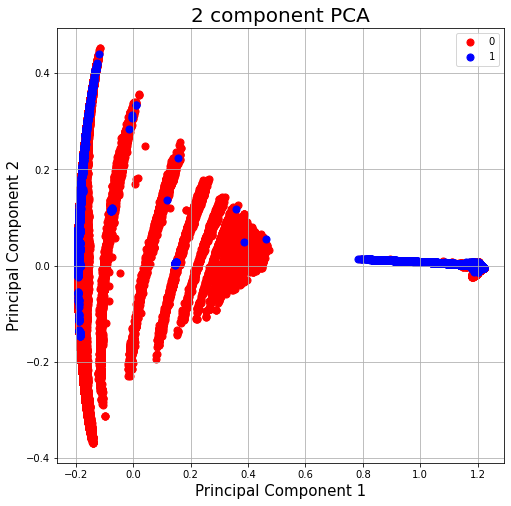

In [24]:
mf.draw_pca_2d(mf.get_pca(X_main, y_main, 2))

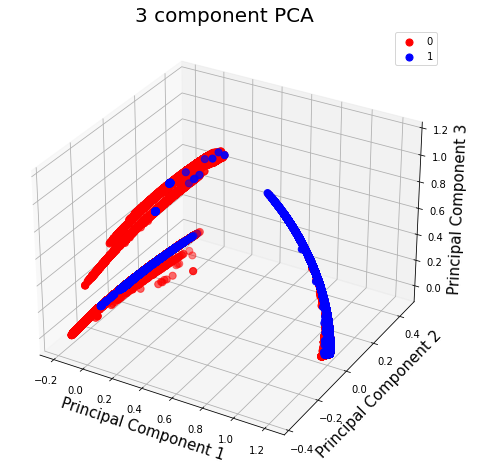

In [33]:
mf.draw_pca_3d(mf.get_pca(X_main, y_main, 3))

# SMOTE oversampling + random undersampling

In [11]:
from imblearn.pipeline import Pipeline
over = imblearn.over_sampling.SMOTENC(sampling_strategy=0.1, categorical_features=[9])
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipe = Pipeline(steps=steps)
X_over, y_over = pipe.fit_resample(X_main, y_main)

In [13]:
X_over.groupby('group_code').size()

group_code
0        529
1       1060
2       6521
3       1836
4        672
5      33100
6       1122
7       1604
8       1363
9      26272
10      2099
11      3863
12      3986
13      7414
14       511
15       647
16    228867
17      7344
18      2199
19      5184
20      9134
21      3928
22     16215
23      1126
24      5512
25     13838
26      1657
27       562
28      5377
29       561
30      4510
31      4357
32       613
33     14936
34     62443
35      1218
36      2629
37       514
38       551
39       555
40     85506
41     44832
42      3207
43      2972
44       538
45       561
46     24449
47     10432
dtype: int64

In [15]:
groups_over = X_over.pop('group_code')

In [14]:
y_over.groupby(y_over).size()

y
0    439284
1    219642
Name: y, dtype: int64

In [17]:
post_smote_df = mf.get_pca(X_over, y_over, 2)

In [18]:
post_smote_df.head()

,component 1,component 2,y
0,-0.480603,-0.010055,0
1,-0.460685,-0.005036,0
2,-0.463614,-0.008161,0
3,-0.480280,-0.009749,0
4,-0.480725,-0.009152,0


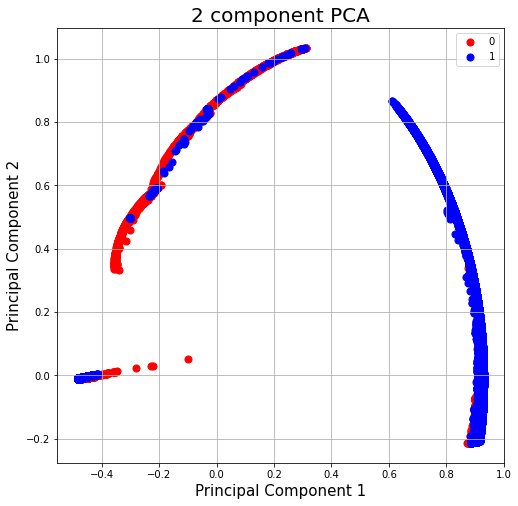

In [19]:
mf.draw_pca_2d(post_smote_df)

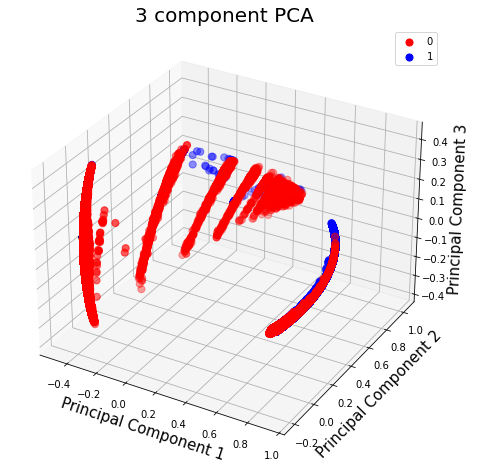

In [20]:
mf.draw_pca_3d(mf.get_pca(X_over, y_over, 3))

## Train Random Forest model on oversampled data

In [24]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

# get X and y
X_learning = X_over.to_numpy()
y_learning = y_over
groups = groups_over.to_numpy()

# train the model
# determine the scoring method
scoring = ['f1']
# create logo cv procedure
logo = LeaveOneGroupOut()
# create model
rfc = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', 
                            max_depth=4, random_state=1)
# evaluate model
results_rfc_smote = cross_validate(rfc, X_learning, y_learning, scoring=scoring, 
                        cv=logo, groups=groups, n_jobs=-1, return_estimator=True)

In [28]:
from joblib import dump
dump(results_rfc_smote, 'test/dfs&results/results_rfc_smote.joblib')

['test/dfs&results/results_rfc_oversampled.joblib']

In [25]:
from joblib import load
results_rfc_smote = load('test/dfs&results/results_rfc_smote.joblib')

In [27]:
# get the probabilities
X_sel_main = df_main.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
prob_df_sel = pd.DataFrame(index=range(len(df_main['y'])), columns=['0', '1'])
prob_df_sel['0'] = prob_df_sel['0'].astype('float')
prob_df_sel['1'] = prob_df_sel['1'].astype('float')
for i in range(0, max(df_main['group_code'])+1):
    mask_main = df_main['group_code'] == i
    prob_df_sel.loc[mask_main, ['0', '1']] = \
        results_rfc_smote['estimator'][i].predict_proba(X_sel_main.loc[mask_main,:].to_numpy())

In [28]:
df_smote_rfc = pd.concat([df_main, prob_df_sel], axis=1)

In [29]:
df_smote_rfc.to_csv('test/dfs&results/df_rfc_smote.tsv', sep='\t')

In [30]:
df_smote_rfc

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1,0.531213,0.468787
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1,0.530230,0.469770
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1,0.530230,0.469770
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1,0.531834,0.468166
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1,0.530230,0.469770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213175,NC_024392,NC_009664,0.0,0.0,0.380006,0.0,0.006918,1.525475,1.535981,0.0,-1.46593,Listeriaceae,22,0,0.997038,0.002962
2213176,NC_024392,NC_011891,0.0,0.0,0.382821,0.0,0.010627,1.509128,1.523096,0.0,-1.47323,Listeriaceae,22,0,0.997038,0.002962
2213177,NC_024392,NC_015514,0.0,0.0,0.382899,0.0,0.007646,1.544129,1.575653,0.0,-1.45837,Listeriaceae,22,0,0.997129,0.002871
2213178,NC_024392,NC_011145,0.0,0.0,0.384063,0.0,0.010793,1.507242,1.526537,0.0,-1.47286,Listeriaceae,22,0,0.997038,0.002962


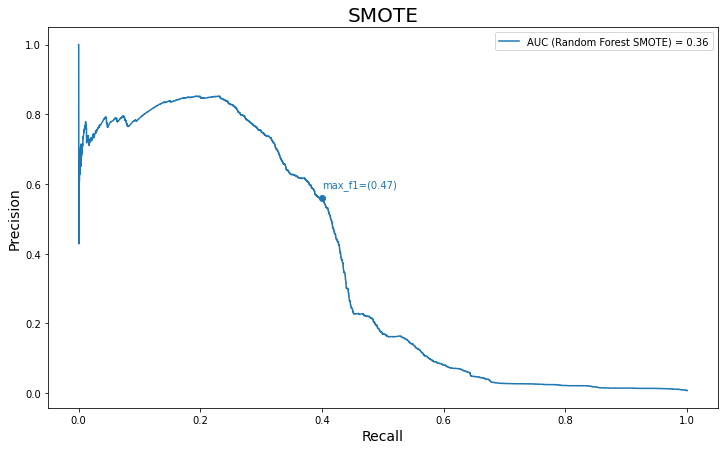

In [ ]:
mf.draw_precision_recall_curve([df_smote_rfc], ['Random Forest SMOTE'], 'SMOTE')

## Visualisation

### Visualisation itself

In [34]:
df_small = pd.read_csv('test/dfs&results/df_all_small.tsv', sep='\t')

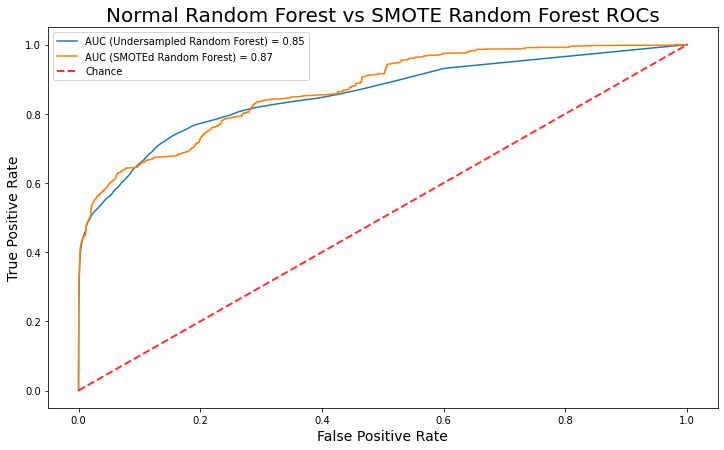

In [35]:
mf.draw_rocs(
    dfs=[
        df_small,
        df_smote_rfc
    ],
    names=[
        'Undersampled Random Forest',
        'SMOTEd Random Forest'
    ],
    plot_name='Normal Random Forest vs SMOTE Random Forest ROCs')

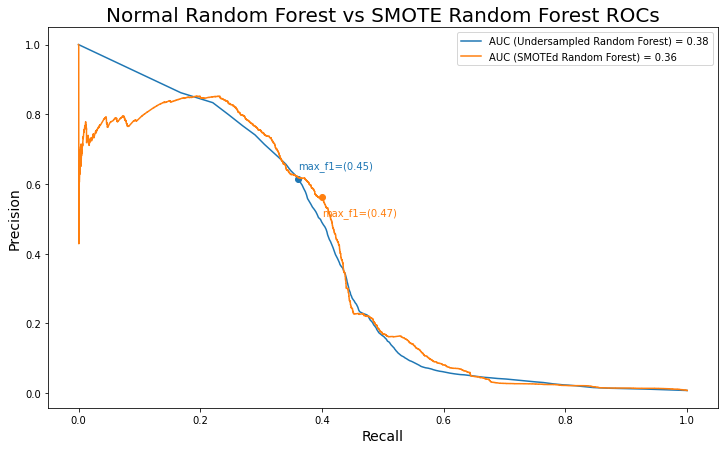

In [36]:
mf.draw_precision_recall_curve(
    dfs=[
        df_small,
        df_smote_rfc
    ],
    names=[
        'Undersampled Random Forest',
        'SMOTEd Random Forest'
    ],
    plot_name='Normal Random Forest vs SMOTE Random Forest ROCs'
)

# Random oversampling

In [6]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [11]:
pipe = Pipeline([('o', RandomOverSampler(sampling_strategy=0.1)), ('u', RandomUnderSampler(sampling_strategy=0.5))])
X_random_over, y_random_over = pipe.fit_resample(X_main, y_main)

In [12]:
groups_random_over = X_random_over.pop('group_code')

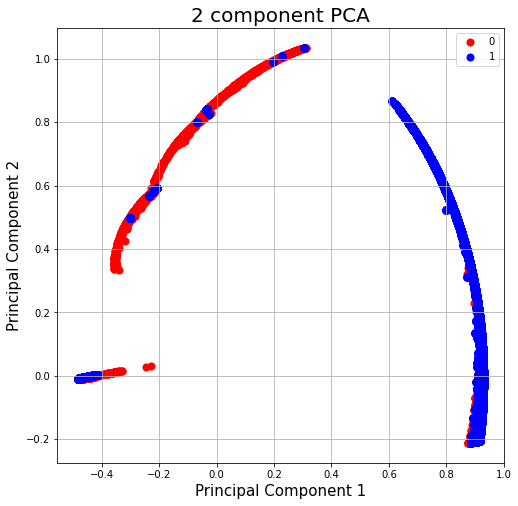

In [45]:
mf.draw_pca_2d(mf.get_pca(X_random_over, y_random_over, 2))

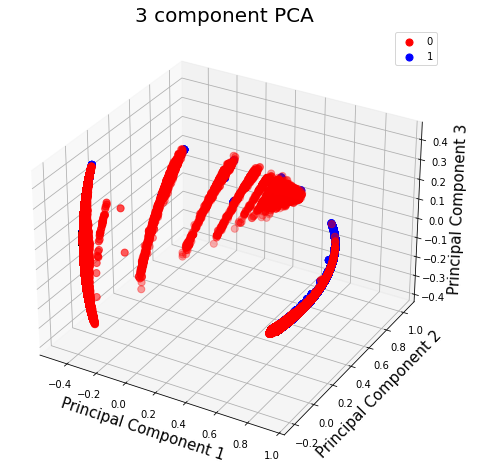

In [46]:
mf.draw_pca_3d(mf.get_pca(X_random_over, y_random_over, 3))

### Random Forest classifier

In [13]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

# get X and y
X_learning = X_random_over.to_numpy()
y_learning = y_random_over
groups = groups_random_over.to_numpy()

# train the model
# determine the scoring method
scoring = ['f1']
# create logo cv procedure
logo = LeaveOneGroupOut()
# create model
rfc = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', 
                            max_depth=4, random_state=1)
# evaluate model
results_rfc_oversampled_random = cross_validate(rfc, X_learning, y_learning, scoring=scoring, 
                        cv=logo, groups=groups, n_jobs=-1, return_estimator=True)

In [15]:
from joblib import dump
dump(results_rfc_oversampled_random, 'test/dfs&results/results_rfc_oversampled_random.joblib')

['test/dfs&results/results_rfc_oversampled_random.joblib']

In [16]:
# get the probabilities
X_sel_main = df_main.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
prob_df_sel = pd.DataFrame(index=range(len(df_main['y'])), columns=['0', '1'])
prob_df_sel['0'] = prob_df_sel['0'].astype('float')
prob_df_sel['1'] = prob_df_sel['1'].astype('float')
for i in range(0, max(df_main['group_code'])+1):
    mask_main = df_main['group_code'] == i
    prob_df_sel.loc[mask_main, ['0', '1']] = \
        results_rfc_oversampled_random['estimator'][i].predict_proba(X_sel_main.loc[mask_main,:].to_numpy())

In [20]:
df_random_oversample_rfc = pd.concat([df_main, prob_df_sel], axis=1)

In [30]:
df_random_oversample_rfc.to_csv('test/dfs&results/df_rfc_random_oversample.tsv', sep='\t')

# Visualisation

In [2]:
df_rfc = pd.read_csv('test/dfs&results/df_all_rfc.tsv', sep='\t')
df_random_oversample_rfc = pd.read_csv('test/dfs&results/df_rfc_random_oversample.tsv', sep='\t')
df_smote_rfc = pd.read_csv('test/dfs&results/df_rfc_smote.tsv', sep='\t')

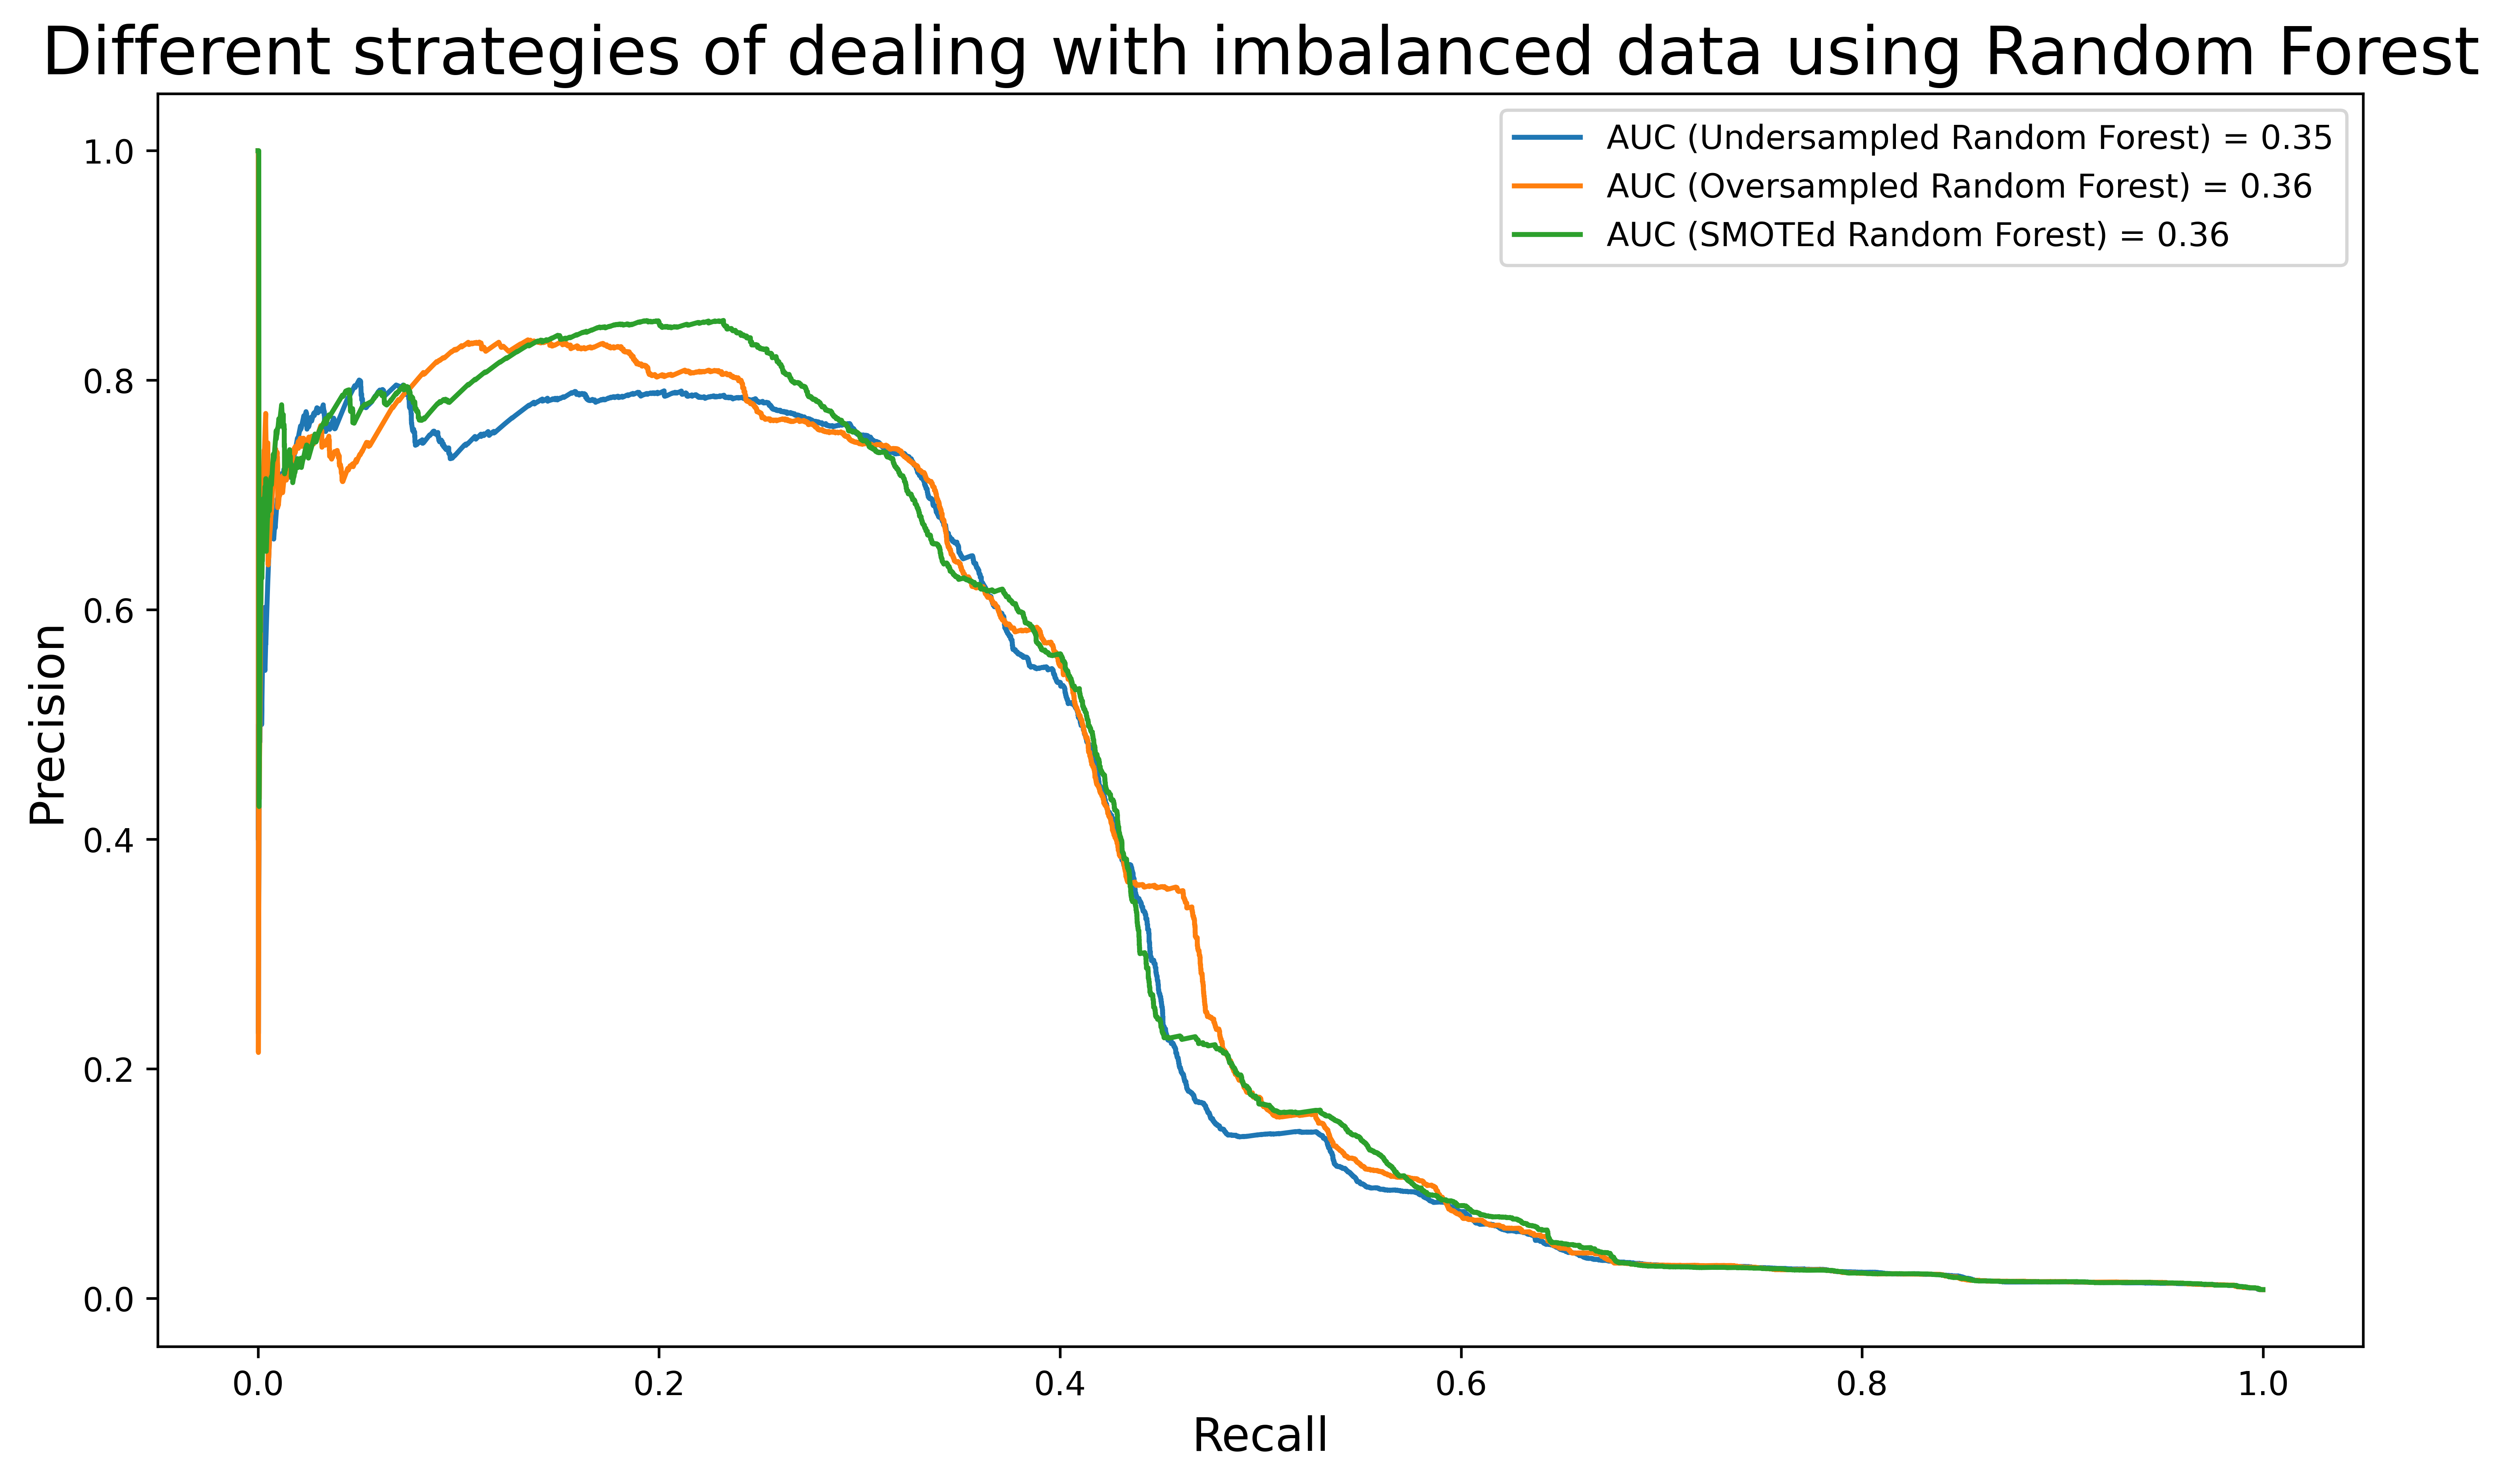

In [4]:
mf.draw_precision_recall_curve(
    dfs=[
        df_rfc,
        df_random_oversample_rfc,
        df_smote_rfc
    ],
    names=[
        'Undersampled Random Forest',
        'Oversampled Random Forest',
        'SMOTEd Random Forest'
    ],
    plot_name='Different strategies of dealing with imbalanced data using Random Forest'
    # plot_name = ''
)

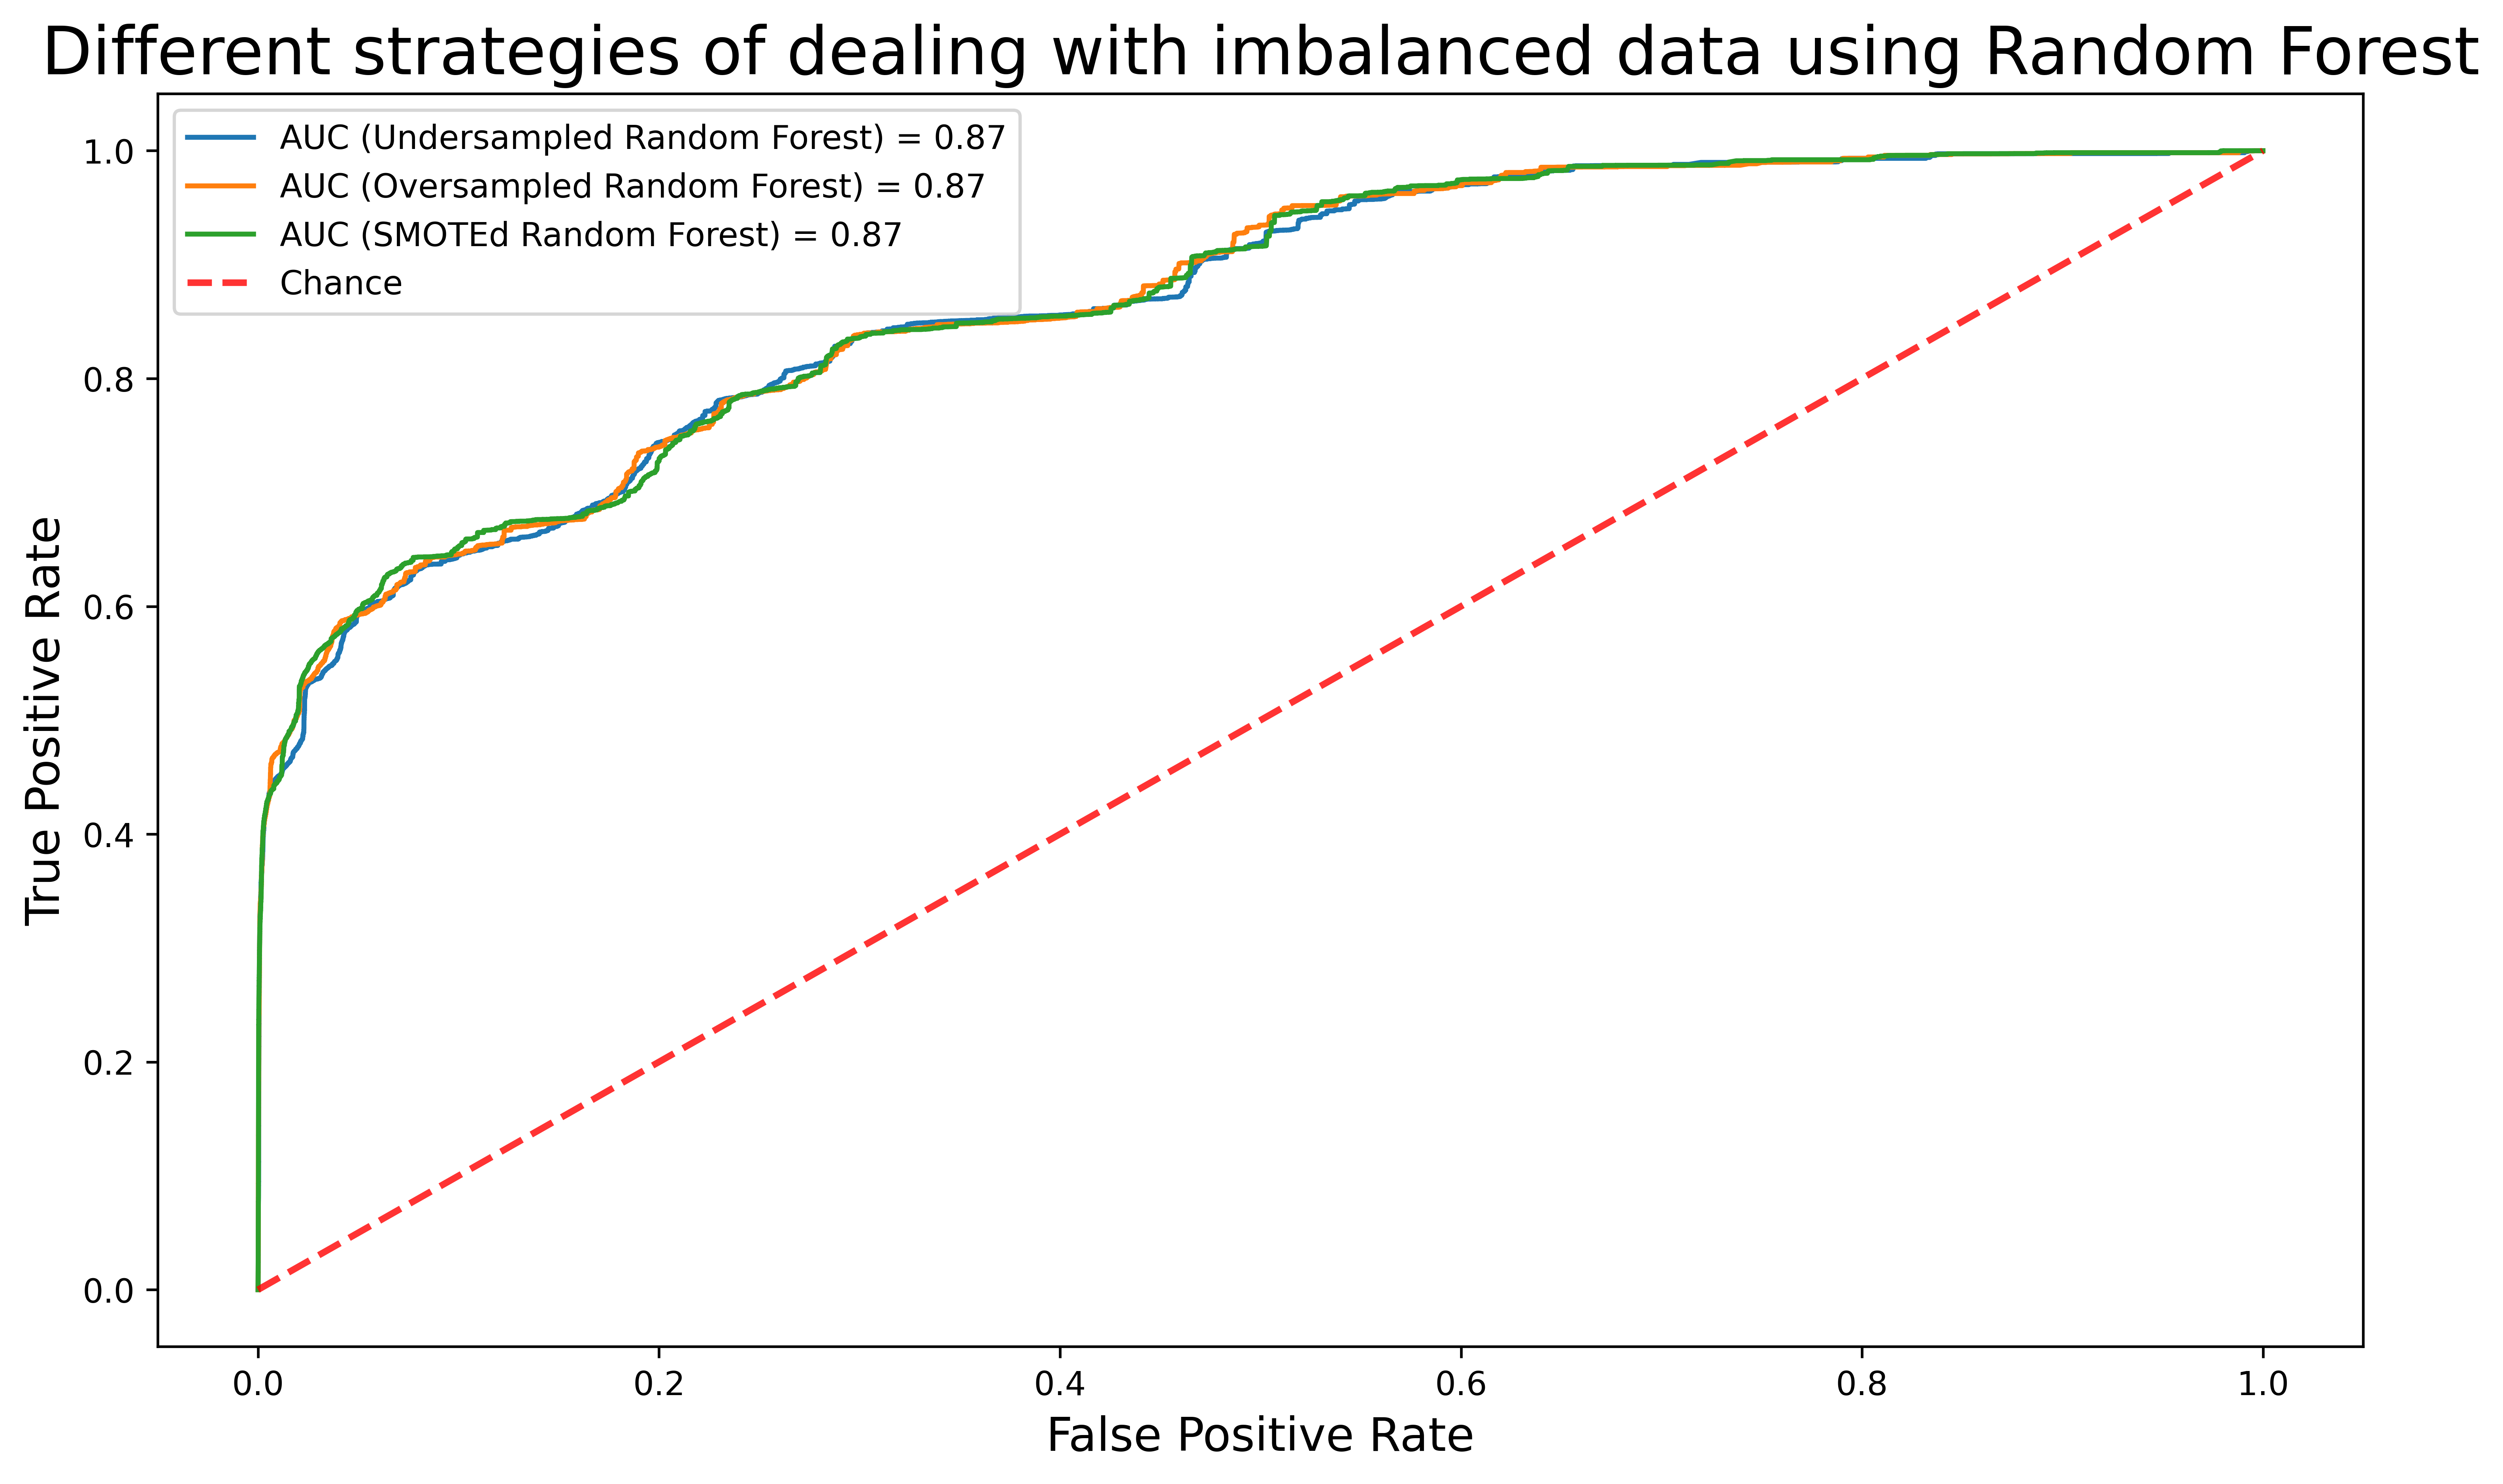

In [5]:
mf.draw_rocs(
    dfs=[
        df_rfc,
        df_random_oversample_rfc,
        df_smote_rfc
    ],
    names=[
        'Undersampled Random Forest',
        'Oversampled Random Forest',
        'SMOTEd Random Forest'
    ],
    plot_name='Different strategies of dealing with imbalanced data using Random Forest'
)

In [6]:
orgs = mf.load_in_taxonomy_json()

In [7]:
dfs=[
    df_rfc,
    df_random_oversample_rfc,
    df_smote_rfc   
]
names=[
    'Undersampling',
    'Random Oversampling',
    'SMOTE Oversampling'
]

In [11]:
percentages_df = pd.DataFrame(index=names, columns=mf.get_correct_preds_percentages(df_rfc, orgs, names[0], sample=False).columns)
for i, df in enumerate(dfs):
    percentages_df.loc[names[i]] = mf.get_correct_preds_percentages(df, orgs, names[i], report=True).values

Undersampling - num of preds with highest prob: 1182, mean = 1.44
Random Oversampling - num of preds with highest prob: 1372, mean = 1.67
SMOTE Oversampling - num of preds with highest prob: 1352, mean = 1.65


In [12]:
percentages_df

,species correct,genus correct,family correct,order correct,class correct,phylum correct,superkingdom correct
Undersampling,35.61,54.88,67.07,72.44,85.37,90.73,100.0
Random Oversampling,36.95,56.83,69.63,74.27,85.98,91.34,100.0
SMOTE Oversampling,38.9,57.07,69.51,74.39,85.85,90.24,100.0


In [13]:
percentages_df.to_csv('test/dfs&results/sampling_df.csv')